In [1]:
import os
from string import Template
from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '..')
from src.data import TimeSeries
from src.methods.spc import FControlChart, PatternFunction
from src.eval import (
    mean_time_from_event,
    classification_metrics
)

In [2]:
ng_train = TimeSeries.from_csv(
    'pandas',
    '../data/nitrogen-generator/train.csv'
)
ng_dev = TimeSeries.from_csv(
    'pandas',
    '../data/nitrogen-generator/val.csv'
)
ng_test = TimeSeries.from_csv(
    'pandas',
    '../data/nitrogen-generator/test.csv'
)
print(ng_train.shape, ng_dev.shape, ng_test.shape)
ng_dev.head()

(40354, 6) (34344, 6) (11162, 6)


,timestamp,CMS air pressure,Concentrazione ossigeno base,Nitrogen pressure,Oxygen over threshold,PW_0.5h
0,2023-08-29 03:39:00,0.407496,-0.184601,-0.116485,-0.044569,0
1,2023-08-29 03:40:00,0.654095,-0.184601,0.522512,-0.044569,0
2,2023-08-29 03:41:00,0.530796,-0.184601,0.522512,-0.044569,0
3,2023-08-29 03:42:00,0.037597,0.216507,1.321258,-0.044569,0
4,2023-08-29 03:43:00,1.147294,0.216507,1.321258,-0.044569,0


In [3]:
timeformat = '%Y-%m-%d %H:%M:%S'

ng_train.parse_datetime('timestamp', timeformat)
ng_dev.parse_datetime('timestamp', timeformat)
ng_test.parse_datetime('timestamp', timeformat)

ng_train.split_by_day()
ng_dev.split_by_day()
ng_test.split_by_day()

len(ng_train.time_series), len(ng_dev.time_series), len(ng_test.time_series)

(29, 25, 8)

In [11]:
splits = [0.25, 0.5, 0.75, 1.0]
ng_train_splits = {}

for pct in splits:
    n_days = len(ng_train.time_series)
    train_days = list(ng_train.time_series.keys())[-int(pct*n_days):]
    y = pd.concat([
        ng_train.time_series[k]['PW_0.5h'] for k in train_days
    ])
    X = pd.concat([
        ng_train.time_series[k].drop(
            columns=['timestamp','PW_0.5h','date','time']
        ) for k in train_days
    ])

    # Drop std=0 variables
    keep_cols = X.columns

    if pct == 0.25:
        keep_cols = X.columns
        X = X[keep_cols]
        
    ng_train_splits.update(
        {
            str(pct):
            {
                'X': X.values,
                'y': y.values,
                'cols': keep_cols.tolist()
            }
        }
    )
    print(f"{pct}\t-\t{X.shape}\t-\t{y.shape}\t-\n{keep_cols.tolist()}\n")

0.25	-	(8859, 4)	-	(8859,)	-
['CMS air pressure', 'Concentrazione ossigeno base', 'Nitrogen pressure', 'Oxygen over threshold']

0.5	-	(18939, 4)	-	(18939,)	-
['CMS air pressure', 'Concentrazione ossigeno base', 'Nitrogen pressure', 'Oxygen over threshold']

0.75	-	(29019, 4)	-	(29019,)	-
['CMS air pressure', 'Concentrazione ossigeno base', 'Nitrogen pressure', 'Oxygen over threshold']

1.0	-	(40354, 4)	-	(40354,)	-
['CMS air pressure', 'Concentrazione ossigeno base', 'Nitrogen pressure', 'Oxygen over threshold']



In [12]:
ng_dev_data = {
    'X': {dt: x[keep_cols].values for dt, x in ng_dev.time_series.items()},
    'y': {dt: x['PW_0.5h'].values for dt, x in ng_dev.time_series.items()}
}
ng_test_data = {
    'X': {dt: x[keep_cols].values for dt, x in ng_test.time_series.items()},
    'y': {dt: x['PW_0.5h'].values for dt, x in ng_test.time_series.items()}
}

In [13]:
charts = {}

for nm, split in ng_train_splits.items():
    print(nm)
    ng_chart = FControlChart()
    ng_chart.determine_parameters(split['X'])
    charts.update(
        {
            nm: ng_chart
        }
    )
    print(ng_chart.lcl, ng_chart.center_line, ng_chart.ucl)

0.25
0.48451472494001707 3.3568159229584165 11.138793865415558
0.5
0.48446352854056235 3.3567510037474384 11.1411852346333
0.75
0.48444790482963407 3.35673119269981 11.141915241438458
1.0
0.4844396604235085 3.3567207387878932 11.142300498403957


In [14]:
def exceeds_n_breaches(values: np.ndarray, ucl, n):
    if (values > ucl).sum() >= 5:
        return True
    return False

def n_sequential_breaches(values: np.ndarray, ucl, n):
    if (values > ucl).sum() == n:
        return True
    return False 

dev_matches = {}
test_matches = {}

for nm, chart in charts.items():
    print(nm)
    dev_matches[nm] = {}
    test_matches[nm] = {}
    
    for n in [5,10,20,40,80]:
        chart.add_patterns(
            {
                f'{n}per{n*2}at0.05': PatternFunction(
                    exceeds_n_breaches,
                    int(n*2),
                    {'ucl': chart.ucl, 'n':n}
                ),
                f'{n}seqAt0.05': PatternFunction(
                    exceeds_n_breaches,
                    int(n),
                    {'ucl': chart.ucl, 'n':n}
                )
            }
        )
    
    for dt, X in ng_dev_data['X'].items():
        matched = chart.check_patterns(X)
        for pattern, res in matched.items():
            if not dev_matches[nm].get(pattern, False):
                dev_matches[nm].update({pattern: {}})
            dev_matches[nm][pattern].update(
                {
                    dt: res
                }
            )
        
    for dt, X in ng_test_data['X'].items():
        matched = chart.check_patterns(X)
        for pattern, res in matched.items():
            if not test_matches[nm].get(pattern, False):
                test_matches[nm].update({pattern: {}})
            test_matches[nm][pattern].update(
                {
                    dt: res
                }
            )
    
    print(len(dev_matches), len(test_matches))

0.25
1 1
0.5
2 2
0.75
3 3
1.0
4 4


In [15]:
res_out = Template(
    "Pattern: $pattern\n"
    "\tMTFE:\t$mtfe\n"
    "\tF1:\t$f1\n"
    "\tRecall:\t$recall\n"
    "\tPrecision:\t$precision\n"
)

ResultTup = namedtuple(
    'ResultTup',
    ['split_pct','pattern','strict','mean_time_from_event','f1','precision','recall']
)

In [17]:
dev_result_for_out = []

print('=== Not Strict ===')
for pct, res in dev_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(ng_dev_data['y'], matches)
        hits, mets = classification_metrics(ng_dev_data['y'], matches)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        dev_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                0,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )

print('\n=== Strict ===')
for pct, res in dev_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(ng_dev_data['y'], matches, strict=True)
        hits, mets = classification_metrics(ng_dev_data['y'], matches, strict=True)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        dev_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                1,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )
        
dev_result_df = pd.DataFrame(dev_result_for_out)
dev_result_df

=== Not Strict ===

=== Strict ===


,split_pct,pattern,strict,mean_time_from_event,f1,precision,recall
0,0.25,5per10at0.05,0,-585.00,0.727273,1.0,0.571429
1,0.25,5seqAt0.05,0,-591.96,0.727273,1.0,0.571429
2,0.25,10per20at0.05,0,-578.36,0.727273,1.0,0.571429
3,0.25,10seqAt0.05,0,-585.00,0.727273,1.0,0.571429
4,0.25,20per40at0.05,0,-592.64,0.727273,1.0,0.571429
...,...,...,...,...,...,...,...
75,1.0,20seqAt0.05,1,-705.40,0.923077,1.0,0.857143
76,1.0,40per80at0.05,1,-715.00,0.923077,1.0,0.857143
77,1.0,40seqAt0.05,1,-708.60,0.923077,1.0,0.857143
78,1.0,80per160at0.05,1,-727.80,0.923077,1.0,0.857143


<Axes: >

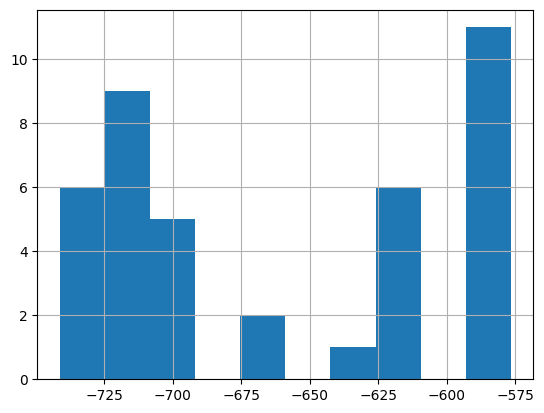

In [18]:
dev_result_df[dev_result_df['strict']==0]['mean_time_from_event'].hist()

<Axes: >

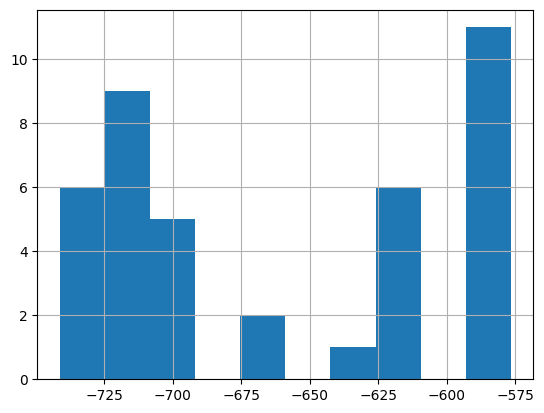

In [19]:
dev_result_df[dev_result_df['strict']==1]['mean_time_from_event'].hist()

In [21]:
test_result_for_out = []

print('=== Not Strict ===')
for pct, res in test_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(ng_test_data['y'], matches)
        hits, mets = classification_metrics(ng_test_data['y'], matches)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        test_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                0,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )

print('\n=== Strict ===')
for pct, res in test_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(ng_test_data['y'], matches, strict=True)
        hits, mets = classification_metrics(ng_test_data['y'], matches, strict=True)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
#         test_result_for_out.append(
        ResultTup(
            pct,
            pattern,
            1,
            mtfe,
            mets['f1'],
            mets['precision'],
            mets['recall']
        )
    
test_result_df = pd.DataFrame(test_result_for_out)
test_result_df

=== Not Strict ===

=== Strict ===


,split_pct,pattern,strict,mean_time_from_event,f1,precision,recall
0,0.25,5per10at0.05,0,-504.125,1.000000,1.0,1.0
1,0.25,5seqAt0.05,0,-544.000,1.000000,1.0,1.0
2,0.25,10per20at0.05,0,-511.875,1.000000,1.0,1.0
3,0.25,10seqAt0.05,0,-504.125,1.000000,1.0,1.0
4,0.25,20per40at0.05,0,-526.875,1.000000,1.0,1.0
5,0.25,20seqAt0.05,0,-511.875,1.000000,1.0,1.0
6,0.25,40per80at0.05,0,-556.875,1.000000,1.0,1.0
7,0.25,40seqAt0.05,0,-526.875,1.000000,1.0,1.0
8,0.25,80per160at0.05,0,-617.625,1.000000,1.0,1.0
9,0.25,80seqAt0.05,0,-556.875,1.000000,1.0,1.0


<Axes: >

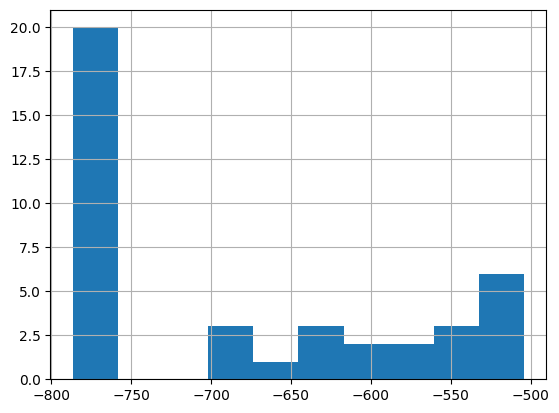

In [23]:
test_result_df[test_result_df['strict']==0]['mean_time_from_event'].hist()

<Axes: >

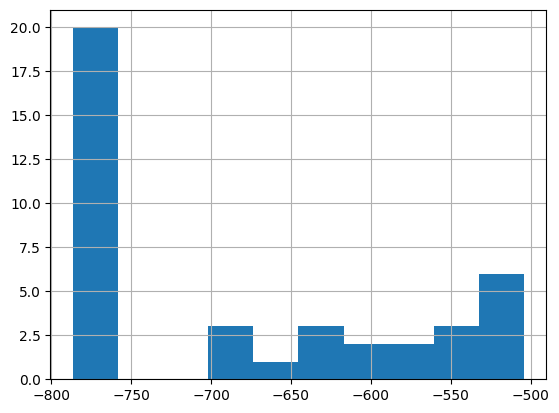

In [24]:
test_result_df[test_result_df['strict']==0]['mean_time_from_event'].hist()

In [ ]:
dev_result_df.to_csv(
    '../results/ng_fcontrolchart_dev_results.csv',
    sep='\t',
    header=True,
    index=False
)
test_result_df.to_csv(
    '../results/ng_fcontrolchart_test_results.csv',
    sep='\t',
    header=True,
    index=False
)